In [1]:
import cantera as ct    # import cantera
import math             # import math (sqrt, exp, etc.)
from scipy.integrate import solve_ivp  # solves ODE (initial value problems)
import scipy.integrate as integrate
import matplotlib.pyplot as plt      # does matlab-like plotting
import numpy as np                    # does a bunch of array stuff

In [2]:
gas = ct.Solution('chem.cti')

In [3]:
def CV_Reactor_RHS(t,y,gas,density):
    # t = time
    # y = the solution vector: y[0] = temperature, y[1:nSpecies] = mass fractions
    
    dy = np.zeros(np.size(y)) # initialize the RHS vector
    
    
    # get T and Y_i from the solution vector.
    # T is the first (0) index of the solution array y[0]
    # all indexes after 0, y[1:], are the mass fractions
    T = y[0];
    massFrac = y[1:];

    # Now we set the species composition.  Here we use a special version that 
    # does not normalize the mass fractions to sum to unity.  Solving systems
    # of ODEs like this are one of the few cases where you do not want
    # to normalize the mass fractions.  
    
    # Swagnik, in case you get a question: This has to do with computing the
    # Jacobian using finite differences.  If Y_i were normalized than perturbing one
    # will perturb all of the others, which messes up the Jacobian computation. 
    gas.set_unnormalized_mass_fractions(massFrac)
    
    # set the state using the density (density is constant for this case, 
    # but pressure is not.  So we have to set the thermodynamic state using 
    # the temperature and density. )
    gas.TD=T, density #gas.density_mass
    

    

    # Now that the thermodynamic state is set, we can compute the chemical
    # rate of production, species internal energies, cv, etc. 
    wdot = gas.net_production_rates      # get the species MOLAR production rate
    mws  = gas.molecular_weights         # get the species MW_i
    ui = gas.partial_molar_int_energies  # get the species internal energy on a MOLAR basis
    cv = gas.cv_mass                     # get the mixture CV on a MASS basis
        
    # form the RHS for a CV adiabatic reactor
    dTdt = -np.sum(wdot*ui)/(density*cv)   # the sum function sums elements over an array
                                           # you don't need the .* as in Matlab
    dYdt = wdot*mws/density
    
    # stuff the temperature and mass fraction time derivatives into an array
    dy[0 ] = dTdt
    dy[1:] = dYdt
    
    return dy

In [4]:
def integrate_CV_reactor(gas, tEnd,atol=1.e-10, rtol=1.e-8):
    rho = gas.density_mass # compute the density on a mass basis

    # set the initial conditions for the reactor
    y =  np.zeros(gas.n_species+1) 
    y[0] = gas.T
    y[1:] = gas.Y

    # solve the ODEs for the CV reactor.  This is equivalent to ode15s in Matlab.
    soln = integrate.solve_ivp(fun=lambda t, y: CV_Reactor_RHS(t,y,gas,rho), 
                               t_span=[0,tEnd],y0=y,method='BDF',rtol=rtol,atol=atol);
    return soln

In [5]:
def P_heat_release_CV_Reactor(soln, gas):
    # Compute the pressure and rate of heat release based on the solution
    # to a CV reactor
    
    # find the number of time points and pre-allocate an array
    npt = len(soln.t)
    p_hr = np.zeros((2,npt))
    
    # loop over over each time, set the gas composition and compute the pressure.  
    for i in range(npt):
        # set the gas composition.  Note: the y[1:,i] grabs all elements in the array after 1
        gas.TDY = soln.y[0,i], gas.density_mass, soln.y[1:,i] 
        p = gas.P # compute the pressure
        
        # compute the chemical heat release rate
        hr = -np.sum(gas.net_production_rates*gas.partial_molar_int_energies)
        
        # store the pressure and heat release rate
        p_hr[0,i] = p
        p_hr[1,i] = hr
        
    return p_hr

def compute_CV_ignition_delay(gas,soln, tShift = 600.):
    # compute the ignition delay time from the solution to a CV reactor.  
    # this is (crudely) based on the time when the temperatur increases 
    # by a specified value from the initial reactant temperature
    npt = len(soln.t)    
    tInit = soln.y[0,0]
    
    for i in range(npt):
        if (soln.y[0,i] > tInit + tShift):
            break
            
    t_ign = soln.t[i]
    
    return t_ign

In [6]:
#PART A

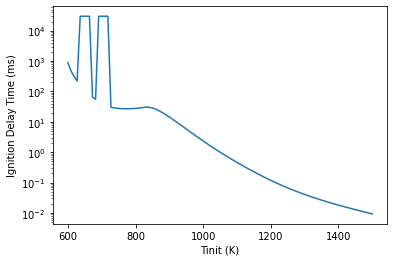

In [7]:
#PRF-0

npts = 100

tInit = np.linspace(600,1500,npts)
tIgn = np.zeros(npts)

fuel = 'IC8H18:1'
ox = 'O2:1, N2:3.76'

for i in range(npts):
    
    gas.set_equivalence_ratio(0.3, fuel, ox)
    
    gas.TP = tInit[i], 4053000
    
    soln = integrate_CV_reactor(gas, 30.)
    
    tIgn[i] = compute_CV_ignition_delay(gas,soln, tShift = 600.)
    
plt.semilogy(tInit,tIgn*1000)
plt.xlabel('Tinit (K)')
plt.ylabel('Ignition Delay Time (ms)')
plt.show()

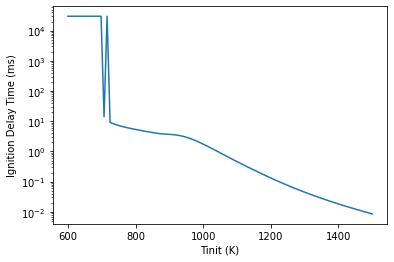

In [8]:
#PRF-50

npts = 102

tInit = np.linspace(600,1500,npts)
tIgn = np.zeros(npts)

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

for i in range(npts):
    
    gas.set_equivalence_ratio(0.3, fuel, ox)
    
    gas.TP = tInit[i], 4053000
    
    soln = integrate_CV_reactor(gas, 30.)
    
    tIgn[i] = compute_CV_ignition_delay(gas,soln, tShift = 600.)
    
plt.semilogy(tInit,tIgn*1000)
plt.xlabel('Tinit (K)')
plt.ylabel('Ignition Delay Time (ms)')
plt.show()

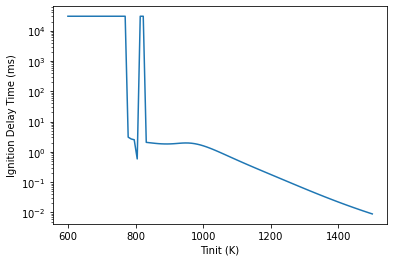

In [9]:
#PRF-100

npts = 102

tInit = np.linspace(600,1500,npts)
tIgn = np.zeros(npts)

fuel = 'IC8H18:0, NC7H16:1'
ox = 'O2:1, N2:3.76'

for i in range(npts):
    
    gas.set_equivalence_ratio(0.3, fuel, ox)
    
    gas.TP = tInit[i], 4053000
    
    soln = integrate_CV_reactor(gas, 30.)
    
    tIgn[i] = compute_CV_ignition_delay(gas,soln, tShift = 600.)
    
plt.semilogy(tInit,tIgn*1000)
plt.xlabel('Tinit (K)')
plt.ylabel('Ignition Delay Time (ms)')
plt.show()

In [10]:
#PART B

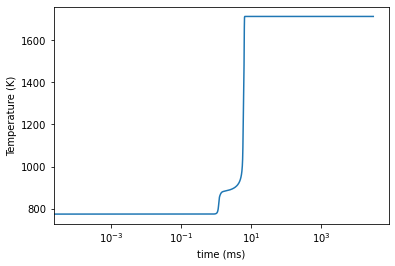

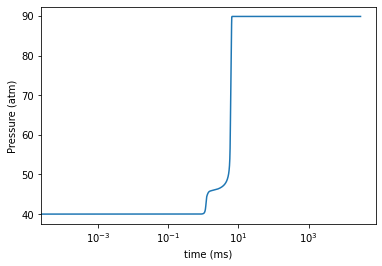

In [11]:
#775K

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

gas.TP = 775, 4053000

gas.set_equivalence_ratio(0.3, fuel, ox)

soln = integrate_CV_reactor(gas, 30.)

temp_index = 0

plt.semilogx(soln.t*1000, soln.y[temp_index,:])
plt.xlabel('time (ms)')
plt.ylabel('Temperature (K)')
plt.show()

p_hr = P_heat_release_CV_Reactor(soln, gas)
plt.semilogx(soln.t*1000, p_hr[0,:]/101325)
plt.xlabel('time (ms)')
plt.ylabel('Pressure (atm)')
plt.show()

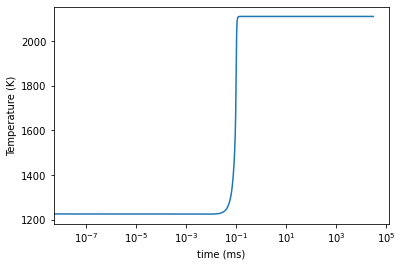

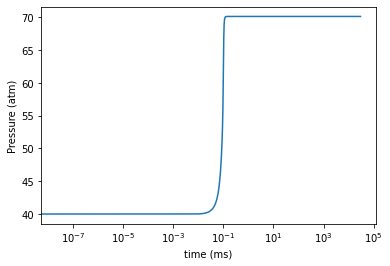

In [12]:
#1225K

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

gas.TP = 1225, 4053000

gas.set_equivalence_ratio(0.3, fuel, ox)

soln = integrate_CV_reactor(gas, 30.)

temp_index = 0

plt.semilogx(soln.t*1000, soln.y[temp_index,:])
plt.xlabel('time (ms)')
plt.ylabel('Temperature (K)')
plt.show()

p_hr = P_heat_release_CV_Reactor(soln, gas)
plt.semilogx(soln.t*1000, p_hr[0,:]/101325)
plt.xlabel('time (ms)')
plt.ylabel('Pressure (atm)')
plt.show()

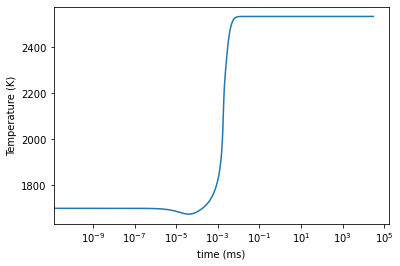

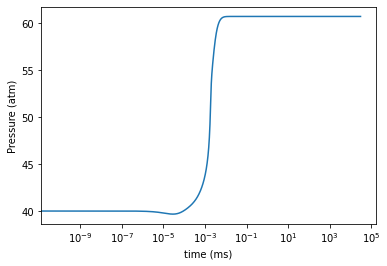

In [13]:
#1700K

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

gas.TP = 1700, 4053000

gas.set_equivalence_ratio(0.3, fuel, ox)

soln = integrate_CV_reactor(gas, 30.)

temp_index = 0

plt.semilogx(soln.t*1000, soln.y[temp_index,:])
plt.xlabel('time (ms)')
plt.ylabel('Temperature (K)')
plt.show()

p_hr = P_heat_release_CV_Reactor(soln, gas)
plt.semilogx(soln.t*1000, p_hr[0,:]/101325)
plt.xlabel('time (ms)')
plt.ylabel('Pressure (atm)')
plt.show()

In [14]:
#PART C

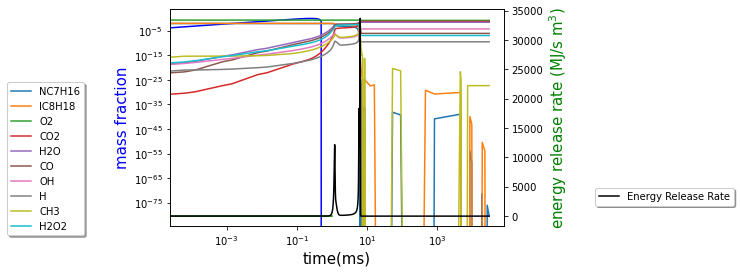

In [15]:
T = 775
P = 4053000

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

gas.TP = T, P
gas.set_equivalence_ratio(0.3, fuel, ox)

soln = integrate_CV_reactor(gas, 30.)

nNC7H16 = gas.species_index('NC7H16') + 1
nIC8H18 = gas.species_index('IC8H18') + 1
nO2 = gas.species_index('O2') + 1
nCO2 = gas.species_index('CO2') + 1
nH2O = gas.species_index('H2O') + 1
nCO = gas.species_index('CO') + 1
nOH = gas.species_index('OH') + 1
nH = gas.species_index('H') + 1
nCH3 = gas.species_index('CH3') + 1
nH2O2 = gas.species_index('H2O2') + 1

p_hr = P_heat_release_CV_Reactor(soln, gas)


x = np.linspace(0,1)
y1 = np.sin(2*np.pi*x)
y2 = 10*x**2

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x,y1,'b')
ax2.plot(x,y2,'g')

ax1.semilogy(soln.t*1000,soln.y[nNC7H16,:], label = 'NC7H16')
ax1.semilogy(soln.t*1000,soln.y[nIC8H18,:], label = 'IC8H18')
ax1.semilogy(soln.t*1000,soln.y[nO2,:], label = 'O2')
ax1.semilogy(soln.t*1000,soln.y[nCO2,:], label = 'CO2')
ax1.semilogy(soln.t*1000,soln.y[nH2O,:], label = 'H2O')
ax1.semilogy(soln.t*1000,soln.y[nCO,:], label = 'CO')
ax1.semilogy(soln.t*1000,soln.y[nOH,:], label = 'OH')
ax1.semilogy(soln.t*1000,soln.y[nH,:], label = 'H')
ax1.semilogy(soln.t*1000,soln.y[nCH3,:], label = 'CH3')
ax1.semilogy(soln.t*1000,soln.y[nH2O2,:], label = 'H2O2')
plt.xscale("log")

ax2.plot(soln.t*1000, p_hr[1,:]/1E6, label = 'Energy Release Rate', color="black")

ax1.legend(loc="best", bbox_to_anchor=[-0.5, 0.684],
           ncol=1, shadow=True,  fancybox=True,fontsize='medium')

ax2.legend(loc="best", bbox_to_anchor=[1.7, 0.2],
           ncol=1, shadow=True,  fancybox=True,fontsize='medium')

# Set the Axes labels
ax1.set_xlabel('time(ms)', fontsize=15,color='k')
ax1.set_ylabel('mass fraction', fontsize=15, color='b')
ax2.set_ylabel('energy release rate (MJ/s m$^3$)', fontsize=15,color='g')

plt.show()

In [16]:
#PART D

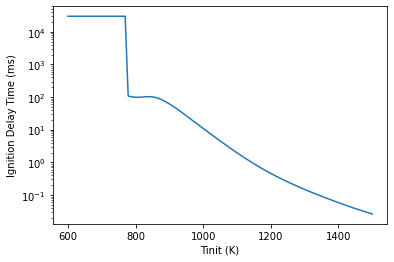

In [17]:
#5 atm

npts = 102

tInit = np.linspace(600,1500,npts)
tIgn = np.zeros(npts)

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

for i in range(npts):
    
    gas.set_equivalence_ratio(0.3, fuel, ox)
    
    gas.TP = tInit[i], 506625
    
    soln = integrate_CV_reactor(gas, 30.)
    
    tIgn[i] = compute_CV_ignition_delay(gas,soln, tShift = 600.)
    
plt.semilogy(tInit,tIgn*1000)
plt.xlabel('Tinit (K)')
plt.ylabel('Ignition Delay Time (ms)')
plt.show()

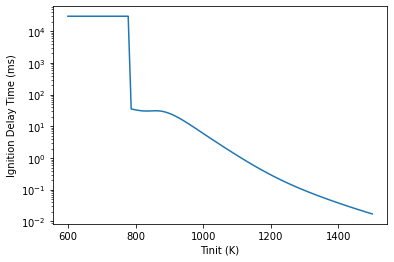

In [18]:
#10 atm

npts = 102

tInit = np.linspace(600,1500,npts)
tIgn = np.zeros(npts)

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

for i in range(npts):
    
    gas.set_equivalence_ratio(0.3, fuel, ox)
    
    gas.TP = tInit[i], 1013000
    
    soln = integrate_CV_reactor(gas, 30.)
    
    tIgn[i] = compute_CV_ignition_delay(gas,soln, tShift = 600.)
    
plt.semilogy(tInit,tIgn*1000)
plt.xlabel('Tinit (K)')
plt.ylabel('Ignition Delay Time (ms)')
plt.show()

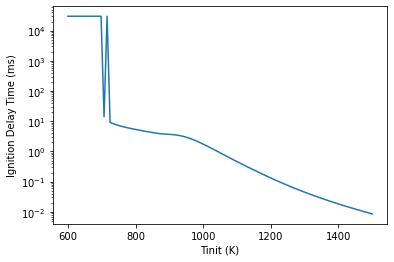

In [19]:
#40 atm

npts = 102

tInit = np.linspace(600,1500,npts)
tIgn = np.zeros(npts)

fuel = 'IC8H18:1, NC7H16:1'
ox = 'O2:1, N2:3.76'

for i in range(npts):
    
    gas.set_equivalence_ratio(0.3, fuel, ox)
    
    gas.TP = tInit[i], 4053000
    
    soln = integrate_CV_reactor(gas, 30.)
    
    tIgn[i] = compute_CV_ignition_delay(gas,soln, tShift = 600.)
    
plt.semilogy(tInit,tIgn*1000)
plt.xlabel('Tinit (K)')
plt.ylabel('Ignition Delay Time (ms)')
plt.show()